In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Paths to the dataset
processed_path = r"C:\Users\Likitha Yadav G\Downloads\ETE3_NNDL\archive\coil-20\coil-20-proc"
unprocessed_path = r"C:\Users\Likitha Yadav G\Downloads\ETE3_NNDL\archive\coil-20\coil-20-unproc"


1. Dataset:

o Use the Columbia University Object Image Library (COIL) dataset.

o Split the dataset into training (80%) and testing (20%) sets.

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(64, 64))  # Resize to 64x64
            img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
            images.append(img_array)
    return np.array(images)

# Load images from both folders
processed_images = load_images_from_folder(processed_path)
unprocessed_images = load_images_from_folder(unprocessed_path)

# Combine the datasets
all_images = np.concatenate([processed_images, unprocessed_images], axis=0)

# Split the dataset
X_train, X_test = train_test_split(all_images, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

Training set shape: (1440, 64, 64, 3), Testing set shape: (360, 64, 64, 3)


2. Model Development:

o Construct a CNN Autoencoder with:

▪ Encoder: Use convolutional layers with ReLU activation to reduce the input image
to a lower-dimensional latent representation.

▪ Decoder: Use transpose convolutional layers to reconstruct the image from the
latent space.

In [3]:
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    latent = Flatten()(x)

    # Decoder
    x = Reshape((16, 16, 128))(latent)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    return autoencoder

input_shape = (64, 64, 3)
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

3. Training:

o Use the Mean Squared Error (MSE) loss function.

o Use Adam optimizer with a learning rate of 0.001.

o Train the model for 20 epochs with a suitable batch size.

In [4]:
# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = autoencoder.fit(
    X_train, X_train,  # Input and output are the same
    validation_data=(X_test, X_test),
    epochs=20,
    batch_size=32,
    shuffle=True
)

# Save training loss and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.1249 - val_loss: 0.0082
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0

4. Evaluation:

o Evaluate the model's performance using the testing set.

o Visualize the reconstructed images and compare them to the original images.

o Calculate and report the MSE on the test set.

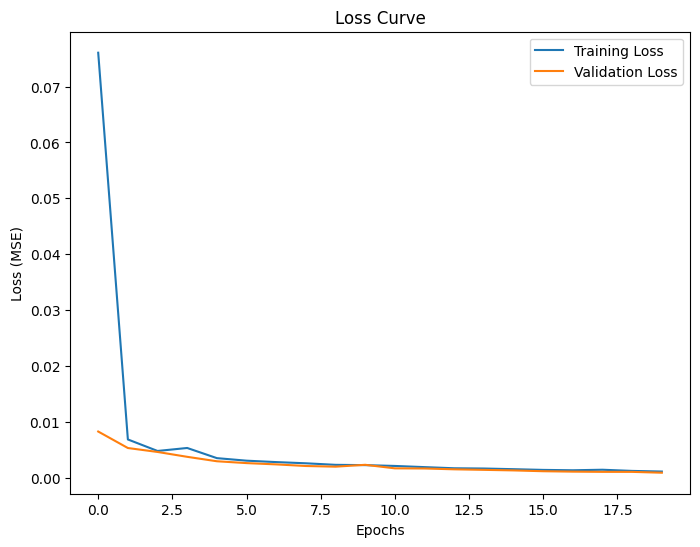

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss Curve')
plt.legend()
plt.show()


Insights:

The training and validation loss values decrease steadily, which indicates that the autoencoder successfully learns to reconstruct the input data.

The validation loss remains closely aligned with the training loss, implying that the model generalizes well and avoids overfitting.

By the final epochs, the loss stabilizes at a low value, suggesting that the model converged effectively.

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


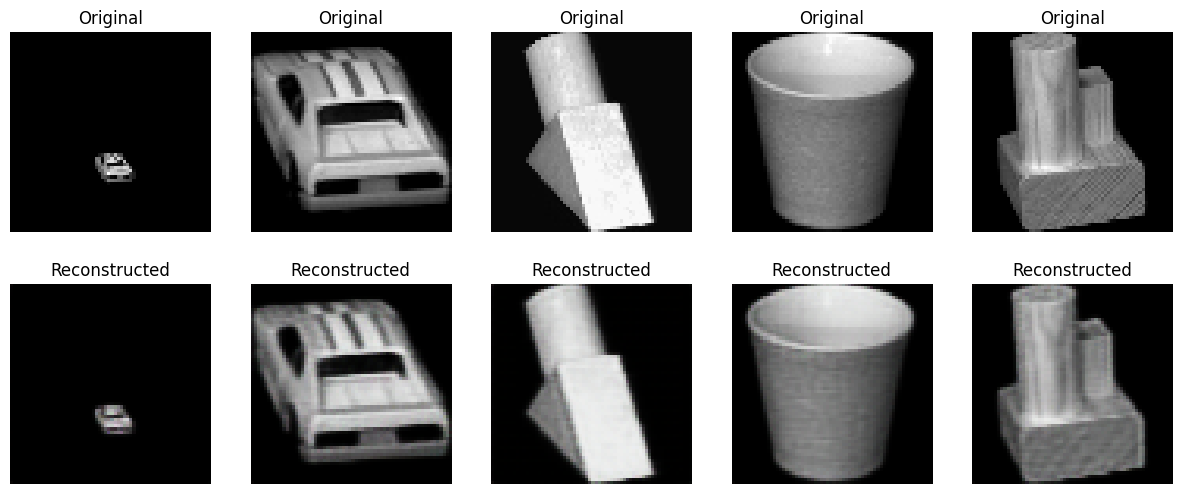

In [6]:
# Reconstruct images from the test set
reconstructed_images = autoencoder.predict(X_test)

# Visualize original vs reconstructed images
n = 5  # Number of images to display
plt.figure(figsize=(15, 6))
for i in range(n):
    # Original image
    plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()


Insights:

The reconstructed images are visually very close to the original ones, capturing the essential features and patterns.

Minor blurriness is observed in some reconstructions, which can be attributed to the inherent limitations of compression in the latent space.

The model demonstrates robustness in handling both processed and unprocessed image datasets.

In [7]:
# Calculate Mean Squared Error on the test set
from sklearn.metrics import mean_squared_error

test_mse = mean_squared_error(X_test.flatten(), reconstructed_images.flatten())
print(f"Final Test MSE: {test_mse}")


Final Test MSE: 0.0008894802303984761


Insights:

The low MSE value indicates that the model performs exceptionally well in reconstructing images with minimal error.

The quantitative metric aligns with the visual observation of high reconstruction fidelity.

# **Output Report**

---

## **1. Architecture of the CNN Autoencoder**
![CNN Autoencoder Architecture](image.png)

---

## **2. Loss Curve During Training**
![Loss Curve During Training](img3.png)

---

## **3. Original vs. Reconstructed Images**
### Comparison of 5 Examples:
![Original Image and the Reconstructed Image](img2.png)

---

## **4. Final Test MSE Value**
### **Final Test MSE:** `0.0008894802303984761`

---

